In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Refrence https:https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [2]:
file = '/content/weather.csv'
aus = pd.read_csv(file,header=0,parse_dates=False)
aus.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12/1/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,12/2/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12/3/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,12/4/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,12/5/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

In [3]:
aus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
aus.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

I will adress the missing values while doing preprocessing 

Checking for duplicated values

In [5]:
aus.duplicated().sum()

0

In [6]:
aus['RainToday'].value_counts()

No     110319
Yes     31880
Name: RainToday, dtype: int64

Checking for Inconsistences

In [7]:
aus['Location'].value_counts()

Canberra            3436
Sydney              3344
Perth               3193
Darwin              3193
Brisbane            3193
Hobart              3193
Melbourne           3193
Adelaide            3193
Ballarat            3040
MountGinini         3040
AliceSprings        3040
Townsville          3040
Albury              3040
GoldCoast           3040
MountGambier        3040
Launceston          3040
Wollongong          3040
Cairns              3040
Albany              3040
Bendigo             3040
Tuggeranong         3039
Penrith             3039
Newcastle           3039
Watsonia            3009
WaggaWagga          3009
MelbourneAirport    3009
PerthAirport        3009
Williamtown         3009
Dartmoor            3009
Cobar               3009
Sale                3009
PearceRAAF          3009
Richmond            3009
Portland            3009
Nuriootpa           3009
CoffsHarbour        3009
NorfolkIsland       3009
BadgerysCreek       3009
Woomera             3009
Moree               3009


Univariate analysis

Does Is it going to rain tomorrow ? what are the odds

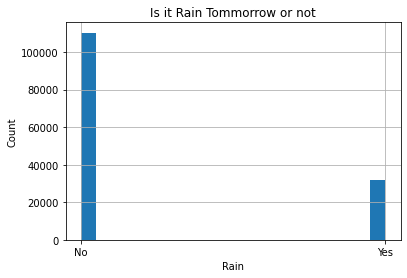

In [8]:
aus['RainTomorrow'].hist(bins = 20)
plt.xlabel('Rain')
plt.ylabel('Count')
plt.title('Is it Rain Tommorrow or not')
plt.show()

The hist says says 'No' is more than 'Yes' so chance of rain will be less 

What are the location where there is chance of rain

In [9]:
aus.loc[((aus['RainTomorrow' ] == 'Yes') & aus['Location']),:]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
8,12/9/2008,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
10,12/11/2008,Albury,13.4,30.4,0.0,NaN,NaN,N,30.0,SSE,ESE,17.0,6.0,48.0,22.0,1011.8,1008.7,NaN,NaN,20.4,28.8,No,Yes
11,12/12/2008,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,ENE,15.0,13.0,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,Yes,Yes
12,12/13/2008,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,NNW,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8,Yes,Yes
16,12/17/2008,Albury,14.1,20.9,0.0,NaN,NaN,ENE,22.0,SSW,E,11.0,9.0,69.0,82.0,1012.2,1010.4,8.0,1.0,17.2,18.1,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145324,2/10/2017,Uluru,24.8,39.8,0.4,NaN,NaN,WNW,65.0,E,ENE,15.0,20.0,38.0,24.0,1007.0,1003.6,NaN,NaN,31.5,36.6,No,Yes
145390,4/17/2017,Uluru,19.3,24.4,0.0,NaN,NaN,W,35.0,ESE,SSE,7.0,19.0,28.0,91.0,1015.9,1013.9,8.0,8.0,21.3,18.5,No,Yes
145391,4/18/2017,Uluru,15.2,21.5,6.8,NaN,NaN,ENE,30.0,NE,ENE,19.0,9.0,65.0,65.0,1016.9,1015.3,3.0,8.0,19.0,21.2,Yes,Yes
145392,4/19/2017,Uluru,17.7,26.9,12.6,NaN,NaN,S,35.0,E,SSW,15.0,20.0,93.0,59.0,1018.1,1014.7,7.0,8.0,19.0,26.0,Yes,Yes


What's the maximum temparature for tmrw if it rain ?

In [10]:
df = aus.groupby(['RainTomorrow'])[['MaxTemp']].max()
df



,MaxTemp
RainTomorrow,
No,48.1
Yes,46.8


In [11]:
aus.loc[(aus['RainToday' ] == 'Yes') & aus['Location'],:]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
9,12/10/2008,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No
11,12/12/2008,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,ENE,15.0,13.0,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,Yes,Yes
12,12/13/2008,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,NNW,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8,Yes,Yes
13,12/14/2008,Albury,12.6,21.0,3.6,NaN,NaN,SW,44.0,W,SSW,24.0,20.0,65.0,43.0,1001.2,1001.8,NaN,7.0,15.8,19.8,Yes,No
17,12/18/2008,Albury,13.5,22.9,16.8,NaN,NaN,W,63.0,N,WNW,6.0,20.0,80.0,65.0,1005.8,1002.2,8.0,1.0,18.0,21.5,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145325,2/11/2017,Uluru,22.2,39.4,6.2,NaN,NaN,S,30.0,S,W,19.0,9.0,56.0,25.0,1008.4,1004.9,NaN,4.0,28.6,38.7,Yes,No
145391,4/18/2017,Uluru,15.2,21.5,6.8,NaN,NaN,ENE,30.0,NE,ENE,19.0,9.0,65.0,65.0,1016.9,1015.3,3.0,8.0,19.0,21.2,Yes,Yes
145392,4/19/2017,Uluru,17.7,26.9,12.6,NaN,NaN,S,35.0,E,SSW,15.0,20.0,93.0,59.0,1018.1,1014.7,7.0,8.0,19.0,26.0,Yes,Yes
145393,4/20/2017,Uluru,18.6,28.6,34.6,NaN,NaN,E,46.0,E,E,4.0,9.0,100.0,56.0,1020.0,1015.8,8.0,5.0,19.8,26.9,Yes,Yes


WindGust speed analysis

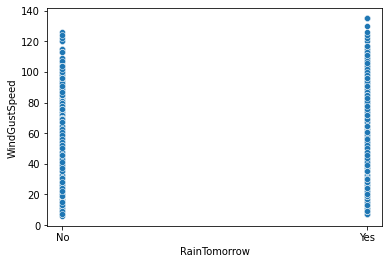

<Figure size 720x576 with 0 Axes>

In [12]:
sns.scatterplot(x='RainTomorrow', y = 'WindGustSpeed', data = aus)
plt.figure(figsize=(10,8))
plt.show()

We can see when windgust speed is more chance when there is rain

Distibution of Each features using histogram

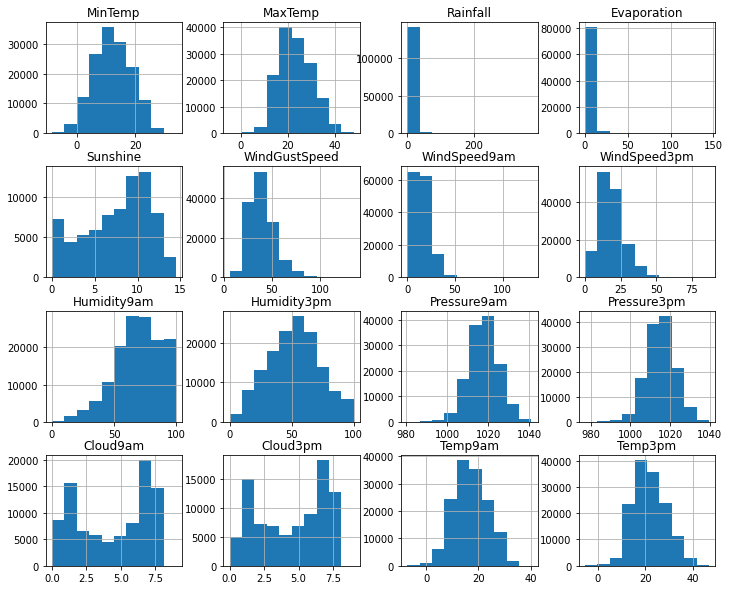

In [13]:
aus.hist(figsize=(12,10))
plt.show()

Stastical anaysis of numerical variables 

In [14]:
aus.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


Distribution of Rainfall

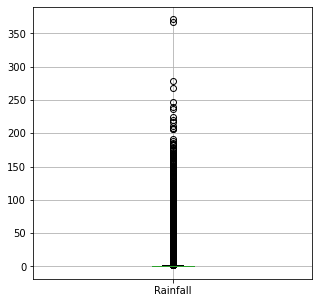

In [15]:
aus.boxplot(column='Rainfall',figsize=(5,5))
plt.show()

we can see there are outliers in the distibution of rain fall there values after 371mm, so those days will be heavy rain,and most of the values including avg vale lies 2.71 mm




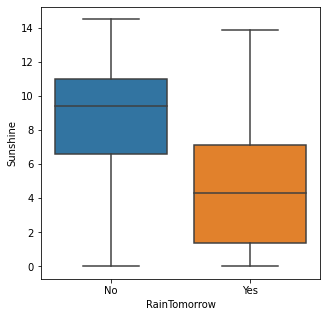

In [16]:
plt.rcParams.update({'font.size': 10})
plt.subplots(figsize=(5, 5))
sns.boxplot(data = aus, x="RainTomorrow", y = 'Sunshine')

We can see when there is rain sunshine will be less than when there is no rain, it can also says most of the rain can occur at night time and there are not outliers 

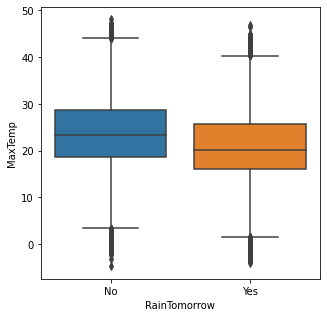

In [17]:
plt.rcParams.update({'font.size': 10})
plt.subplots(figsize=(5, 5))
sns.boxplot(data = aus, x="RainTomorrow", y = 'MaxTemp')

we can see  avg tempratures will be less when there is raining there are outleirs (-5) in boxplot where Rain is No after which means there where days which went extreme cold 

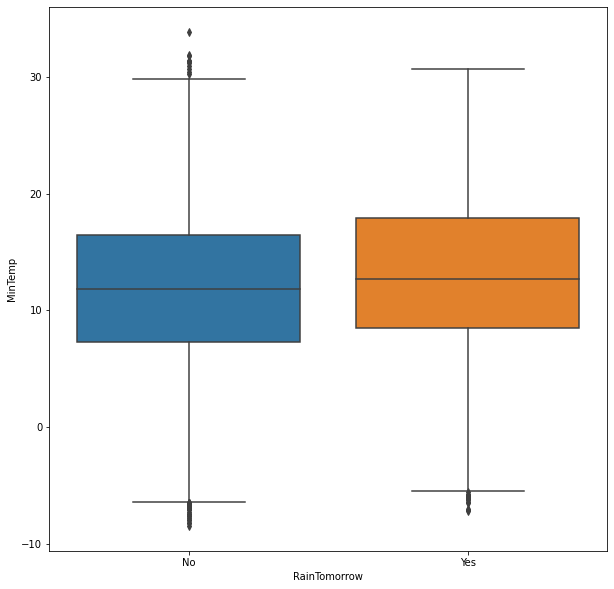

In [18]:
plt.subplots(figsize=(10, 10))
sns.boxplot(data = aus, x="RainTomorrow", y = 'MinTemp')

Pressure at 3pm anaysis 

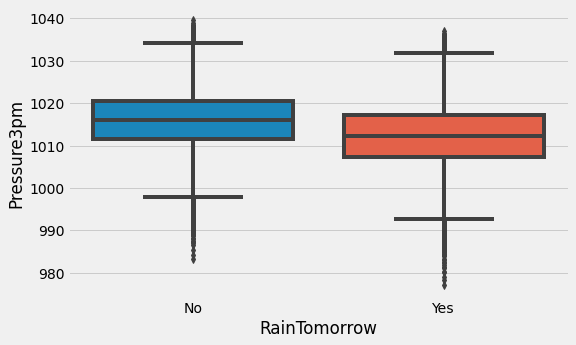

In [19]:
plt.rcParams.update({'font.size': 10})
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(8, 5)) 
sns.boxplot(data = aus, x='RainTomorrow', y = "Pressure3pm")

we can see there are no outliers in both , and also we can see when there is rain then pressure is low compared to when there is no rain 

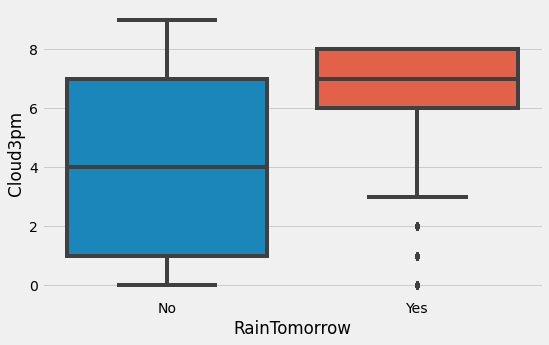

In [20]:
plt.rcParams.update({'font.size': 10})
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(8, 5)) 
sns.boxplot(data = aus, x='RainTomorrow', y = 'Cloud3pm')

ofcourse clouds will be more thick when there is rain, than when there is no rain, but also we can see some outliers in cloud when there is rain

let's check the corelation

In [21]:
#changing Rain today and Rain tomorrow columsn values into 0 and 1(ordinal columns )

In [22]:
aus['RainToday'].replace({'Yes': 1, 'No': 0}, inplace=True)
aus['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace=True)

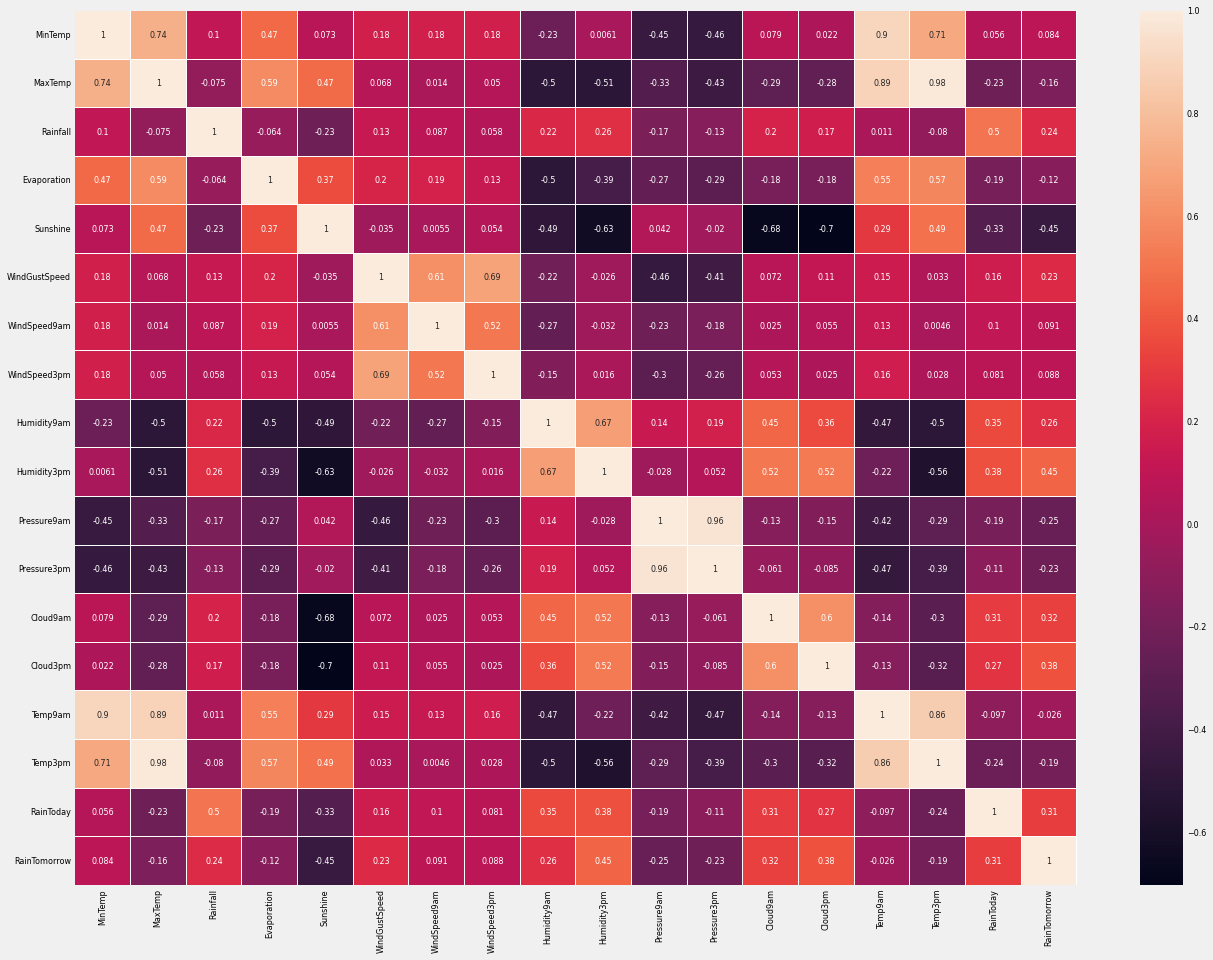

In [23]:
corr = aus.corr()
plt.rcParams.update({'font.size': 8})
plt.subplots(figsize=(20,15))
sns.heatmap(corr, annot =True,linewidths=.1);

We can see the Target 'RainTomorrow is corelated to Rain Today ,cloud 9 am, cloud 3 am, Humidity 3 pm and negatively corelated to sunshine, these corelated features makes significant roles in prediction 

Preprocessing

In [24]:
#Since date is not useful for prediction I'm dropping Date column

In [25]:
aus.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12/1/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,12/2/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,12/3/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,12/4/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,12/5/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


In [26]:
aus.dropna(subset=['RainTomorrow'],inplace=True)

In [27]:
aus['RainTomorrow'].value_counts()

0.0    110316
1.0     31877
Name: RainTomorrow, dtype: int64

In [28]:
X = aus.drop(columns=['Date','RainTomorrow','Evaporation','Sunshine','Cloud9am','Cloud3pm'])
y= aus['RainTomorrow']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [29]:
num_select = make_column_selector(dtype_include='number')
cat_select = make_column_selector(dtype_include='object')
mean_imput= SimpleImputer(strategy='median')
freq_imput = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
num_pipe = make_pipeline(mean_imput, scaler)
cat_pipe = make_pipeline(freq_imput, encoder)
num_tuple = (num_pipe, num_select)
cat_tuple = (cat_pipe, cat_select)
column_transform = make_column_transformer(num_tuple,cat_tuple)

The nominal columns are encoded and  missing values handeled and numerical columns are scaled ,so Data is cleaned


So Data is cleaned 

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

In [32]:
knn = KNeighborsClassifier()
pipe1 = make_pipeline(column_transform,knn)
pipe1.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd6e8d97f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                              

In [33]:
print('classification report for test set')
test_report1 = classification_report(y_test,pipe1.predict(X_test))
print(test_report1)

classification report for test set
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     27623
         1.0       0.68      0.46      0.55      7926

    accuracy                           0.83     35549
   macro avg       0.77      0.70      0.72     35549
weighted avg       0.82      0.83      0.82     35549



In [34]:
print('Testing accuracy:', pipe1.score(X_test, y_test))
print('Training accuracy:',pipe1.score(X_train,y_train))

Testing accuracy: 0.8320065262032688
Training accuracy: 0.8783616518510183


we can see that accuracy between test and train are almost equal so we can see that it's good fit

In [35]:
print('confusion matrix of test set')
test_matrix = confusion_matrix(y_test,pipe1.predict(X_test),normalize='true')
print(test_matrix)

confusion matrix of test set
[[0.93795026 0.06204974]
 [0.53721928 0.46278072]]


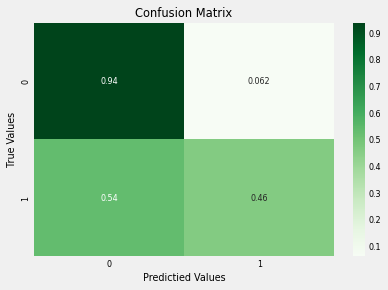

In [36]:
sns.heatmap(test_matrix,annot=True,cmap = 'Greens')
plt.ylabel('True Values')
plt.xlabel('Predictied Values')
plt.title('Confusion Matrix')
plt.show()

Let's Logistic Regression alogrithm

In [39]:
log = LogisticRegression()
pipe2 = make_pipeline(column_transform,log)
pipe2.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd6e8d97f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                              

In [40]:
print('classification report for training set')
train_report = classification_report(y_train,pipe2.predict(X_train))
print(train_report)

print('classification report for test set')
test_report = classification_report(y_test,pipe2.predict(X_test))
print(test_report)

classification report for training set
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     82693
         1.0       0.73      0.50      0.59     23951

    accuracy                           0.85    106644
   macro avg       0.80      0.72      0.75    106644
weighted avg       0.84      0.85      0.83    106644

classification report for test set
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     27623
         1.0       0.72      0.50      0.59      7926

    accuracy                           0.84     35549
   macro avg       0.79      0.72      0.75     35549
weighted avg       0.83      0.84      0.83     35549



In [41]:
print('Testing accuracy:', pipe2.score(X_test, y_test))
print('Training accuracy:',pipe2.score(X_train,y_train))

Testing accuracy: 0.8447776308756927
Training accuracy: 0.8460297813285323


we can see that there is not that much difference betweeen train and test score, so it's good fit, let's try to tune to get score near to one

let's do the hyperparamatern tuning using gridsearch cv

In [42]:
pipe2.get_params()

{'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd6e8d97f90>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transfo

In [43]:
param_grid  = {'logisticregression__penalty' : ['l1', 'l2', 'elasticnet'],
      'logisticregression__C': [1, 0.01, 0.1],'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear']}

In [44]:
grid1 = GridSearchCV(pipe2,param_grid,cv = 5)
grid1.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd6e8d97f90>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                             

In [45]:
print('classification report for training set')
train_report = classification_report(y_train,grid1.predict(X_train))
print(train_report)

print('classification report for test set')
test_report = classification_report(y_test,grid1.predict(X_test))
print(test_report)

classification report for training set
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     82693
         1.0       0.73      0.50      0.59     23951

    accuracy                           0.85    106644
   macro avg       0.80      0.72      0.75    106644
weighted avg       0.84      0.85      0.83    106644

classification report for test set
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.90     27623
         1.0       0.72      0.49      0.59      7926

    accuracy                           0.84     35549
   macro avg       0.79      0.72      0.75     35549
weighted avg       0.83      0.84      0.83     35549



In [46]:
print('Testing accuracy:', grid1.score(X_test, y_test))
print('Training accuracy:',grid1.score(X_train,y_train))

Testing accuracy: 0.8445244591971645
Training accuracy: 0.8462642061438056


we can see score has only slightly increases 

Let's try one booster alogrithm

In [47]:
from xgboost import XGBClassifier

In [48]:
xgb = XGBClassifier()
pipe3 = make_pipeline(column_transform,xgb)
pipe3.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd6e8d97f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                              

In [49]:
print('classification report for training set')
train_report = classification_report(y_train,pipe3.predict(X_train))
print(train_report)

print('classification report for test set')
test_report = classification_report(y_test,pipe3.predict(X_test))
print(test_report)

classification report for training set
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     82693
         1.0       0.76      0.48      0.59     23951

    accuracy                           0.85    106644
   macro avg       0.81      0.72      0.75    106644
weighted avg       0.84      0.85      0.84    106644

classification report for test set
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91     27623
         1.0       0.74      0.48      0.58      7926

    accuracy                           0.85     35549
   macro avg       0.80      0.71      0.74     35549
weighted avg       0.84      0.85      0.83     35549



In [50]:
print('Testing accuracy:', pipe3.score(X_test, y_test))
print('Training accuracy:',pipe3.score(X_train,y_train))

Testing accuracy: 0.8463247911333652
Training accuracy: 0.8492085818236376


booster algorith test and test score are almost same let's try to get better score near to one

In [51]:
param_test = {'xgbclassifier__n_estimators':[2,8,9,10,15,20],
               'xgbclassifier__max_depth':range(10,20,25,)}
grid3 = GridSearchCV(pipe3,param_grid=param_test);
grid3.fit(X_train,y_train)
best_param = grid3.best_params_
best_param

{'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 20}

In [52]:
print('classification report for training set')
train_report = classification_report(y_train,grid3.predict(X_train))
print(train_report)

print('classification report for test set')
test_report = classification_report(y_test,grid3.predict(X_test))
print(test_report)

classification report for training set
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     82693
         1.0       0.86      0.58      0.69     23951

    accuracy                           0.88    106644
   macro avg       0.87      0.77      0.81    106644
weighted avg       0.88      0.88      0.87    106644

classification report for test set
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     27623
         1.0       0.75      0.50      0.60      7926

    accuracy                           0.85     35549
   macro avg       0.81      0.73      0.75     35549
weighted avg       0.84      0.85      0.84     35549



In [53]:
print('Testing accuracy:', grid3.score(X_test, y_test))
print('Training accuracy:',grid3.score(X_train,y_train))

Testing accuracy: 0.8517820473149736
Training accuracy: 0.8836596526761937


we can see that after tuning testing accuracy has been slightly increased 

Let's try one tree classifier 

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf = RandomForestClassifier()
pipe4 = make_pipeline(column_transform,rf)
pipe4.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd6e8d97f90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                              

In [56]:
print('classification report for training set')
train_report = classification_report(y_train,pipe4.predict(X_train))
print(train_report)

print('classification report for test set')
test_report = classification_report(y_test,pipe4.predict(X_test))
print(test_report)

classification report for training set
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     82693
         1.0       1.00      1.00      1.00     23951

    accuracy                           1.00    106644
   macro avg       1.00      1.00      1.00    106644
weighted avg       1.00      1.00      1.00    106644

classification report for test set
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     27623
         1.0       0.76      0.49      0.60      7926

    accuracy                           0.85     35549
   macro avg       0.81      0.72      0.75     35549
weighted avg       0.84      0.85      0.84     35549



In [57]:
print('Testing accuracy:', pipe4.score(X_test, y_test))
print('Training accuracy:',pipe4.score(X_train,y_train))

Testing accuracy: 0.8522883906720301
Training accuracy: 0.9998874760886688


we can see that both scores are near to one and there is less difference between them so they are good fit

we can see Random Forest classifier algorthm is producing best test accuracy with goof fit with train accuracy so i like to procced with Random Forest classifier for prediction